In [28]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file

#
# Library loading and additional function definition
#
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np
import scipy

# machine learning
from sklearn.neighbors import KNeighborsRegressor

# error propagation
from uncertainties import unumpy

# for plotting
import matplotlib.pyplot as plt 

import gpvisc
import carter # Import functions from the Carter et al. 2024 code

import gpytorch
import torch
import torch.nn as nn

# import astropy
import astropy.units as u
from astropy.constants import G, h, k_B, c
from scipy.constants import Stefan_Boltzmann as sigma_sb

# CPU or GPU?
device = gpvisc.get_device()

###############################################################
# TEMPERATURE AT THE SURFACE OF A PLANET IRRADIATED BY A STAR #
###############################################################
def calculate_T_surface(
    longitude=np.arange(-180, 180, 1) * u.degree,
    epsilon_5_over_2=1.0,
    R_star=0.943 * u.solRad,
    d_star=0.01544 * u.AU,
    T_star=5172.0 * u.Kelvin,
    nightside_T=1045.0 * u.Kelvin,
):
    """from Leger et al. 2011

    On the nightside, we assume that temperature drops to nightside_T
    """

    T_surf = (
        (epsilon_5_over_2**0.25)
        * ((R_star.si / d_star.si) ** 0.5)
        * (np.cos(longitude.si) ** 0.25)
        * T_star
    )
    T_surf = np.nan_to_num(T_surf, 0)
    T_surf[T_surf < nightside_T] = nightside_T
    return T_surf

def calculate_T_surface_carter(
        
        lon = np.arange(-180, 180, 0.1),
        planet_distance_AU = 0.00716,
        planet_radius_earthUnit = 1.51,
        star_radius_solUnit = 0.681,
        temperature_star_K = 4599.0,
        temperature_nightside_K = 950.0,
        show_figure = True):
    """calculate temperature profile at surface of an exoplanet
    

    Notes
    =====
    The calculation takes into account of the angular size of the star

    Default parameters are for K2-141 b from Malavolta et al. 2018

    This code uses the model and code from Carter 2024
    """
    
    # convert in si
    star_radius_si = (star_radius_solUnit  * u.solRad).si.value
    planet_radius_si = (planet_radius_earthUnit * u.earthRad).si.value
    planet_distance_si = (planet_distance_AU  * u.AU).si.value

    angular_diameter_rad = 2.0*np.arctan((2*star_radius_si)/(2*planet_distance_si))
    angular_diameter_degree = np.rad2deg(angular_diameter_rad)
    print("Star angular size: {}".format(angular_diameter_degree))
    print("Flux at surface assuming parallel beam:")
    print((star_radius_si/planet_distance_si)**2*sigma_sb*temperature_star_K**4)

    # calculate the limits of the different regions
    # formula 1 from Carter et al. 2024
    n_full = np.arcsin((star_radius_si + planet_radius_si)/planet_distance_si)
    n_pen = np.arcsin(planet_radius_si/planet_distance_si)
    n_un = np.arcsin((star_radius_si - planet_radius_si)/planet_distance_si)

    # star intensity 
    Io = sigma_sb * temperature_star_K**4

    # start calculations as in code Carter et al. 2024
    aRs, RpRs = carter.getScaled(planet_distance_AU, planet_radius_earthUnit, star_radius_solUnit)

    # star-planet seperation in units of Rp
    sep_unitsRp = aRs / RpRs

    # stellar radius in units of Rp
    Rs_unitsRp = 1.0 / RpRs
    print(Rs_unitsRp)

    # Ls in units of Rp
    # beware of this!
    Ls = np.pi * Rs_unitsRp**2 * Io

    # coordinates of center of source in units of Rp
    xs = 0
    ys = 0
    zs = sep_unitsRp

    # planet coordinates
    lat = np.zeros(len(lon))

    # get intensities (the interesting one is Ifinite)
    Ifull_divided_by_Ls= carter.getIfull(lat, lon, xs, ys, zs, Rs_unitsRp)
    Ifinite_divided_by_Ls = carter.getIfinite2(lat, lon, xs, ys, zs, Rs_unitsRp, 200)
    Iplane_divided_by_Ls = carter.getIplane(lat, lon, xs, ys, zs)

    # we renormalize the flux
    # as the intensity given by getIfinite2()
    # does not always match well the analytical
    # calculated intensity given by getIfull()
    Ifinite_divided_by_Ls = Ifinite_divided_by_Ls/np.max(Ifinite_divided_by_Ls) * np.max(np.nan_to_num(Ifull_divided_by_Ls))

    # flux in W / m^2
    Fp_stellar_W_m2 = Ifinite_divided_by_Ls.copy() * Ls

    # geothermal flux in W / m^2
    Fp_geoterm_W_m2 = sigma_sb * temperature_nightside_K**4

    # Total flux at planet surface
    Fp = Fp_stellar_W_m2 + Fp_geoterm_W_m2

    # temperature calculation
    T_planet = (Fp/sigma_sb)**(1/4.)

    if show_figure == True:
        # figure
        plt.figure()
        plt.subplot(1,2,1)
        plt.plot(lon, Ifull_divided_by_Ls*1e6, "k-", label="full")
        plt.plot(lon, Ifinite_divided_by_Ls*1e6, "r--", label="finite")
        plt.plot(lon, Iplane_divided_by_Ls*1e6, "b:", label="plane")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(lon, T_planet)

    print("Theta full (from substellar point): {:.1f}".format(90-np.rad2deg(n_full)))
    print("Theta pen (from substellar point): {:.1f}".format(90-np.rad2deg(n_pen)))
    print("Theta night (from substellar point): {:.1f}".format(90+np.rad2deg(n_un)))

    return T_planet

def whittaker(y,**kwargs):
    """smooth a signal with the Whittaker smoother

    Parameters
    ----------
    y : ndarray
        An array with the values to smooth (equally spaced).
    Lambda : float, optional
        The smoothing coefficient, the higher the smoother. Default = 10^5.

    Returns
    -------
    z : ndarray
        An array containing the smoothed values.

    References
    ----------
    P. H. C. Eilers, A Perfect Smoother. Anal. Chem. 75, 3631–3636 (2003).

    """
    # optional parameters
    lam = kwargs.get('Lambda',1.0*10**5)

    # starting the algorithm
    L = len(y)
    D = scipy.sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    W = scipy.sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = scipy.sparse.linalg.spsolve(Z, w*y)

    return z


Will run on cuda


# Test temperature equations

Star angular size: 82.99374705666882
Flux at surface assuming parallel beam:
19851198.31783174
49.19272082833944
Theta full (from substellar point): 25.5
Theta pen (from substellar point): 89.0
Theta night (from substellar point): 150.1
Star angular size: 47.72095444766965
Flux at surface assuming parallel beam:
4962799.579457935
49.19272082833944
Theta full (from substellar point): 63.2
Theta pen (from substellar point): 89.5
Theta night (from substellar point): 115.7
Star angular size: 24.941267726343916
Flux at surface assuming parallel beam:
1240699.8948644837
49.19272082833944
Theta full (from substellar point): 77.0
Theta pen (from substellar point): 89.7
Theta night (from substellar point): 102.5
Star angular size: 12.620091397505458
Flux at surface assuming parallel beam:
310174.97371612093
49.19272082833944
Theta full (from substellar point): 83.5
Theta pen (from substellar point): 89.9
Theta night (from substellar point): 96.2
Star angular size: 5.0652435066804795
Flux at sur

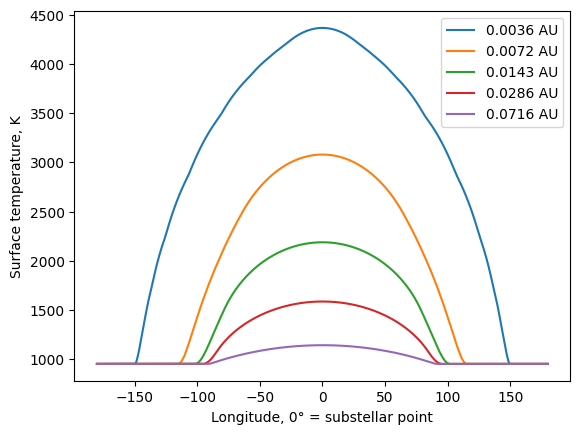

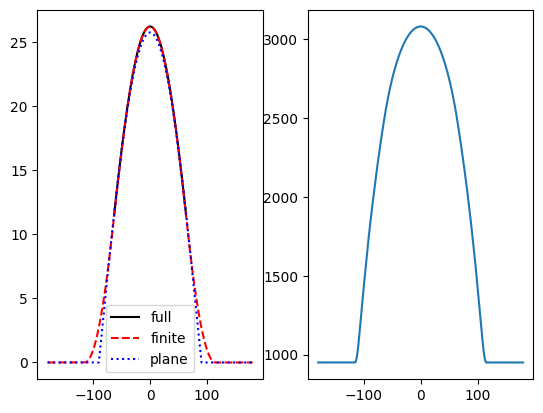

In [29]:
lon = np.arange(-180, 180, 0.1)

a_K2_141_b = 0.00716

multipliers = np.array([0.5,1.0,2.0,4.0,10.])
T_planet_list = []
for i in multipliers:
    T_planet_list.append(calculate_T_surface_carter(lon = lon, 
                                                    planet_distance_AU=i*a_K2_141_b,
                                                    show_figure = False))
    
plt.figure()
for count, i in enumerate(T_planet_list):
    plt.plot(lon, i, label="{:.4f} AU".format(multipliers[count]*a_K2_141_b))

plt.ylabel("Surface temperature, K")
plt.xlabel("Longitude, 0° = substellar point")
plt.legend()
plt.savefig("./dev/Tsurface_f(distance_planet_star).pdf")


T_planet = calculate_T_surface_carter(lon = lon,
                                      show_figure = True)

## Loading the GP model

In [30]:
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)


# Temperature profile on K2-141 b

Star angular size: 47.72095444766965
Flux at surface assuming parallel beam:
4962799.579457935
49.19272082833944
Theta full (from substellar point): 63.2
Theta pen (from substellar point): 89.5
Theta night (from substellar point): 115.7
Maximum temperature is: 3079


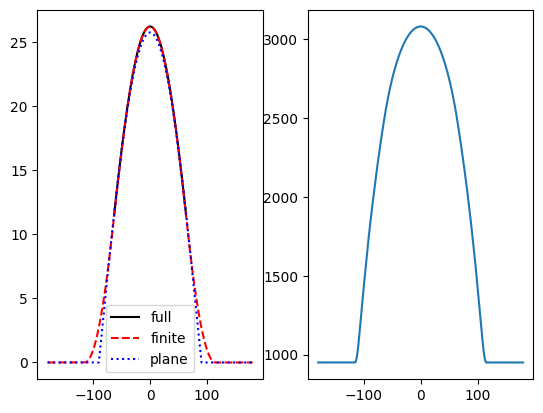

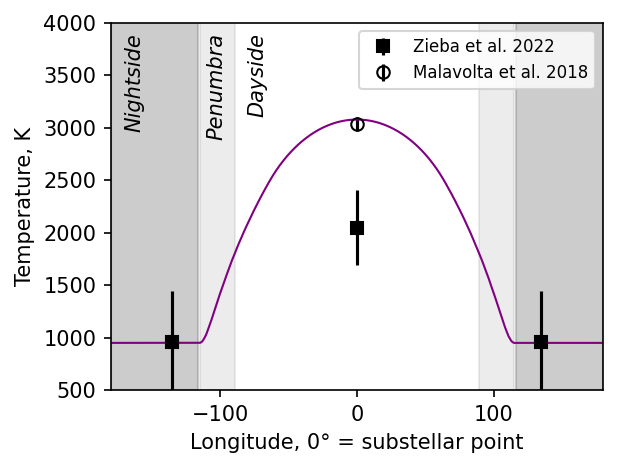

In [31]:
lon = np.arange(-180, 180, 0.1)
T_planet = calculate_T_surface_carter(
    lon = lon,
    planet_distance_AU = 0.00716,
    planet_radius_earthUnit = 1.51,
    star_radius_solUnit = 0.681,
    temperature_star_K = 4599.0,
    temperature_nightside_K = 950.0,
    )

print("Maximum temperature is: {:.0f}".format(np.max(T_planet)))
###
# Figure for temperature
###

plt.figure(figsize=(4.22,3.22), dpi=150)

plt.errorbar(np.array([0., -135, 135]),
             np.array([2049, 956, 956]), 
             yerr=np.array([[359, 556, 556],[362, 489, 489]]),
             marker="s", 
             linestyle="none",
             color="k", label="Zieba et al. 2022")

plt.errorbar(0,3038,
             yerr=64,marker="o", mfc="none", 
             c = "black", linestyle="none", 
             label="Malavolta et al. 2018")

plt.legend(loc="upper right", fontsize=8)#bbox_to_anchor=(1.65, 1.0))

# plot our temperature profile
plt.plot(lon, T_planet, "-", linewidth=1.0, color="purple")

# shaded areas for night, pen, day
plt.fill_betweenx([500,5000],-115,-89, color="grey", alpha=0.15)
plt.fill_betweenx([500,5000],89,115, color="grey", alpha=0.15)

plt.fill_betweenx([500,5000],-116,-180, color="grey", alpha=0.4)
plt.fill_betweenx([500,5000],116,180, color="grey", alpha=0.4)

plt.xlim(-180, 180)
plt.ylim(500,4000)

plt.annotate("Nightside", xy=(-170, 3900), rotation=90, va="top", fontstyle="italic")
plt.annotate("Dayside", xy=(-80, 3900), rotation=90, va="top", fontstyle="italic")
plt.annotate("Penumbra", xy=(-110, 3900), rotation=90, va="top", fontstyle="italic")

plt.ylabel("Temperature, K")
plt.xlabel("Longitude, 0° = substellar point")

plt.tight_layout()
plt.savefig("./figures/Planet_temperature_profile.pdf", bbox_inches="tight")

# BSE composition, 1 bar

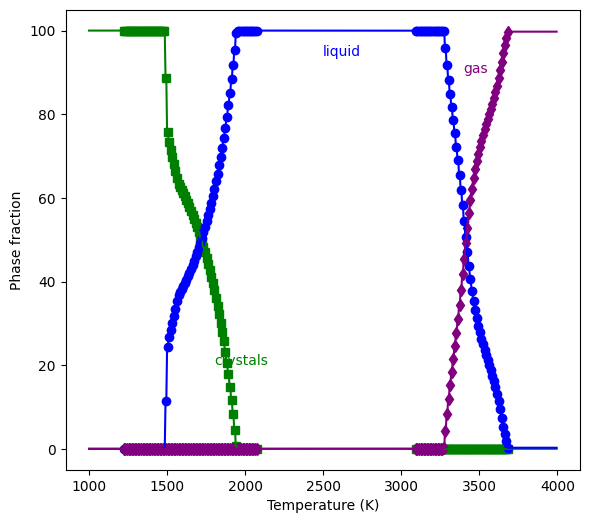

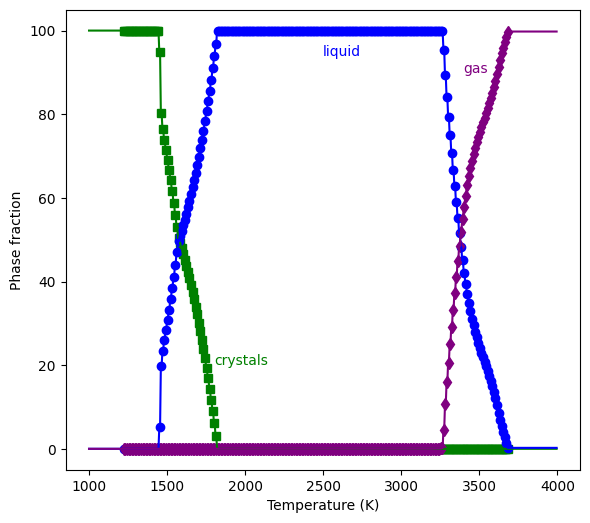

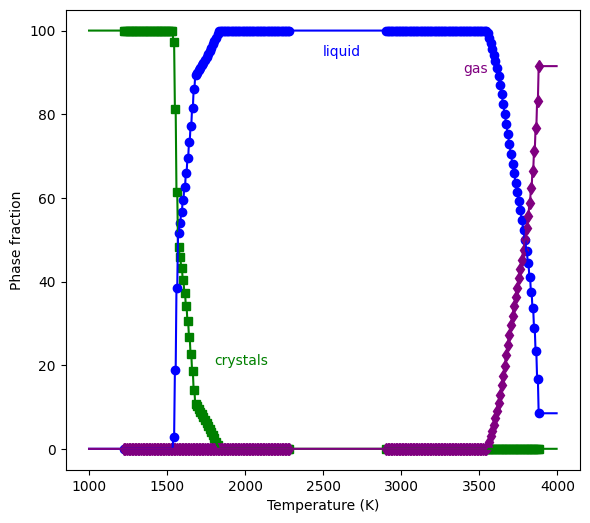

In [32]:
def generate_visco_profile(db, lon, T_planet):
        """generate phase and viscosity longitudinal profile at the
        surface of a planet given composition (db), longitude (lon) and temperature profile (T_planet, K)
        
        db : pandas dataframe
                composition in weight percent
        lon : 1d numpy array containing the longitude in degrees
        T_planet : 1d numpy array containing the temperature profile as a function of lon
        """

        db_mol = gpvisc.wt_mol(gpvisc.chimie_control(db))
        db_mol["prct_c"] = 100 - db_mol["prct_l"]- db_mol["prct_g"] 

        ##############
        # KNR INTERP #
        ##############
        # we use a nearest neighbor algo to link temperature to all other variables
        clf = KNeighborsRegressor(n_neighbors=1, weights='distance')
        clf.fit(db_mol.loc[:, "T_K"].values.reshape(-1,1), 
                db_mol.loc[:, ["sio2", "tio2", "al2o3", "feo", "fe2o3", 
                                "mno", "na2o", "k2o", "mgo", "cao", "p2o5", 
                                "h2o", 'prct_c', 'prct_l', 'prct_g']].values)

        ##########
        # FIGURE #
        ##########
        # plot with an inverse X scale T_K versus prcl_l in compo_1bar
        plt.figure(figsize=(6,8/9*6))

        plt.plot(db_mol["T_K"], db_mol["prct_c"], "s", color="green", label="1 bar")
        plt.plot(db_mol["T_K"], db_mol["prct_l"], "o", color="blue", label="1 bar")
        plt.plot(db_mol["T_K"], db_mol["prct_g"], "d", color="purple", label="1 bar")

        # visualize the ML model
        fake_T = np.arange(1000,4000,5.0)
        plt.plot(fake_T, clf.predict(fake_T.reshape(-1,1))[:,12], "-", color="green")
        plt.plot(fake_T, clf.predict(fake_T.reshape(-1,1))[:,13], "-", color="blue")
        plt.plot(fake_T, clf.predict(fake_T.reshape(-1,1))[:,14], "-", color="purple")

        plt.annotate("liquid", xy=[2500,94], color="blue")
        plt.annotate("gas", xy=[3400,90], color="purple")
        plt.annotate("crystals", xy=[1800,20], color="green")

        # add legend
        plt.xlabel("Temperature (K)")
        plt.ylabel("Phase fraction")
        plt.tight_layout()

        ########################
        # CALCULATE FOR PLANET #
        ########################

        # get the composition via the KNR interpolator
        values_planet = clf.predict(T_planet.reshape(-1,1))

        # declaring the output dataframe
        planet_result = pd.DataFrame(values_planet, columns= ['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                        'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o", 'prct_c', 'prct_l', 'prct_g'])

        # prepare the input for the GP-ANN
        planet_input = gpvisc.scale_for_gaussianprocess(T_planet, np.zeros((len(T_planet),1)), planet_result)

        # get posterior evaluation
        planet_pr_visco_mean, planet_pr_visco_std = gpvisc.predict(planet_input, gp_model, likelihood)

        # creating an uncertainties array for error propagation
        visco_mean_std =  unumpy.uarray(planet_pr_visco_mean, planet_pr_visco_std)

        # adding the effect of crystals
        planet_visco = gpvisc.viscosity_melt_ctx(visco_mean_std, T_planet, planet_result.prct_c.values/100, 
                                                 eta_0 = 10. ** 18., # Pa s
                                                 T_0 = 1273.0, #K 
                                                 phy_m=0.622)

        # updating the output dataframe
        planet_result["visco"] = unumpy.nominal_values(planet_visco)
        planet_result["visco_std"] = unumpy.std_devs(planet_visco)

        # output the dataframe
        return planet_result

################
# IMPORT COMPO #
################

BSE_1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="BSE_1bar")
FBSE_1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="FBSE_1bar")
CAI_1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="CAI_1bar")

BSE_0p1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="BSE_0.1bar")
FBSE_0p1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="FBSE_0.1bar")
CAI_0p1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="CAI_0.1bar")

BSE_0p0001bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="BSE_0.0001bar")
FBSE_0p0001bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="FBSE_0.0001bar")
CAI_0p0001bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name="CAI_0.0001bar")

Result_BSE = generate_visco_profile(BSE_1bar_in, lon, T_planet)
Result_FBSE = generate_visco_profile(FBSE_1bar_in, lon, T_planet)
Result_CAI = generate_visco_profile(CAI_1bar_in, lon, T_planet)


In [33]:
def calculate_outgassing_prob(db, T_planet):
    """calculates the equilibrium proportion of gas as a function of T_planet
    given a compositional database db
    
    """
	# we use a KN regressor as an interpolator
    clf = KNeighborsRegressor(n_neighbors=1, weights='distance')
    db["g_l_ratio"] = np.nan_to_num(db.prct_g/(db.prct_l+db.prct_g))
    clf.fit(db["T_K"].values.reshape(-1,1), 
            db["g_l_ratio"].values.reshape(-1,1))
    
    longitudinal_g_l_ratio = clf.predict(T_planet.reshape(-1,1))
    return longitudinal_g_l_ratio.ravel()

# calculation at 0p1 bar
long_g_l_0p1bar = []
for i in [BSE_0p1bar_in, FBSE_0p1bar_in, CAI_0p1bar_in]:
    long_g_l_0p1bar.append(calculate_outgassing_prob(i, T_planet))

# calculation at 1e-4 bar
long_g_l_0p0001bar = []
for i in [BSE_0p0001bar_in, FBSE_0p0001bar_in, CAI_0p0001bar_in]:
    long_g_l_0p0001bar.append(calculate_outgassing_prob(i, T_planet))

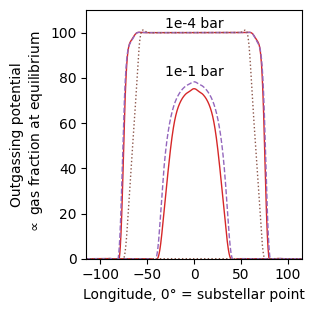

In [34]:
plt.figure(figsize=(3.22,3.22))


#plt.plot(lon, (BSE_eff_), "s", markersize=2)
#plt.plot(lon, (FBSE_eff_), "o", markersize=2)
#plt.plot(lon, (CAI_eff_), "d", markersize=2)

linestyles = ["-", "--", ":"]
colors = ["C3", "C4", "C5"]

for i in range(3):

    plt.plot(lon, whittaker(long_g_l_0p1bar[i])*100, 
             linestyles[i], linewidth=1., c=colors[i])
    
    plt.plot(lon, whittaker(long_g_l_0p0001bar[i])*100, 
             linestyles[i], linewidth=1., c=colors[i])

plt.ylabel("Outgassing potential\n $\propto$ gas fraction at equilibrium")
plt.xlabel("Longitude, 0° = substellar point")

plt.xlim(-115,115)
plt.ylim(-0.,110)

plt.annotate("1e-4 bar", xy=(0, 102), ha="center")
plt.annotate("1e-1 bar", xy=(0, 81), ha="center")

plt.tight_layout()
plt.savefig("./figures/outgassing_efficiency.pdf")

In [35]:
clf = KNeighborsRegressor(n_neighbors=1, weights='distance')
clf.fit(T_planet[lon>=0.].reshape(-1,1), lon[lon>=0.].reshape(-1,1))
BSE_lon_gaz = clf.predict(np.array([1890., 2640., 3010.]).reshape(-1,1)+273.15)
BSE_lon_gaz = np.vstack((-BSE_lon_gaz,np.flip(BSE_lon_gaz)))

FBSE_lon_gaz = clf.predict(np.array([1870., 2630., 3000.]).reshape(-1,1)+273.15)
FBSE_lon_gaz = np.vstack((-FBSE_lon_gaz,np.flip(FBSE_lon_gaz)))

CAI_lon_gaz = clf.predict(np.array([2020., 2860., 3290.]).reshape(-1,1)+273.15)
CAI_lon_gaz = np.vstack((-CAI_lon_gaz,np.flip(CAI_lon_gaz)))

P_gaz = np.array([1e-4, 1e-1, 1.0, 1., 1e-1, 1e-4])

Volat = pd.DataFrame(np.vstack((P_gaz.ravel(), 
                                BSE_lon_gaz.ravel(), 
                                FBSE_lon_gaz.ravel(), 
                                CAI_lon_gaz.ravel())).T,
                     columns=["P_bar", "BSE", "FBSE", "CAI"]).sort_values("BSE")

Volat

,P_bar,BSE,FBSE,CAI
0,0.0001,-77.2,-78.0,-72.3
1,0.1000,-36.2,-37.2,-0.1
2,1.0000,-0.1,-0.1,-0.1
3,1.0000,0.1,0.1,0.1
4,0.1000,36.2,37.2,0.1
5,0.0001,77.2,78.0,72.3


## Plotting the fractions of phases

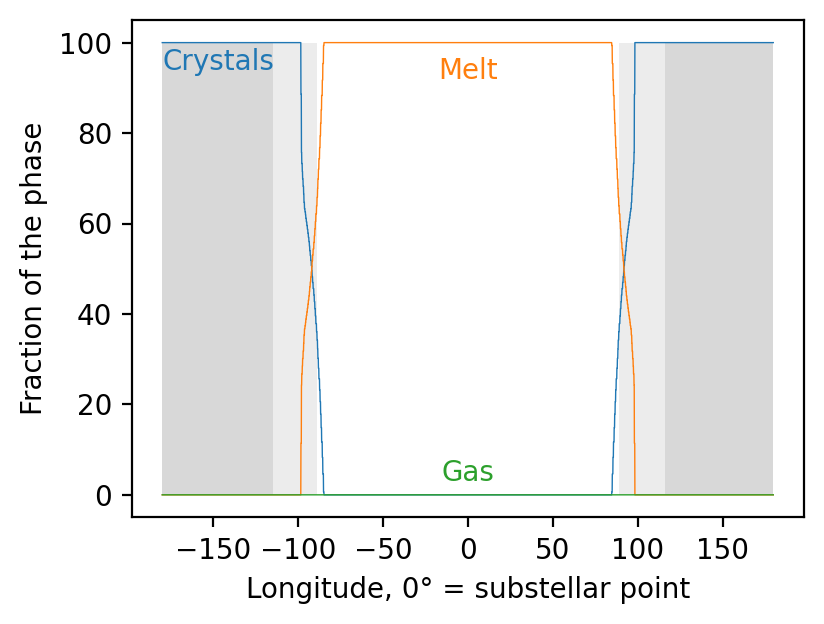

In [36]:
def fill_un_pen_full_regions(y_min, y_max):
    """shaded areas for night, pen, day"""
    plt.fill_betweenx([y_min,y_max],-115,-89, color="grey", alpha=0.15, edgecolor=None)
    plt.fill_betweenx([y_min,y_max],89,116, color="grey", alpha=0.15, edgecolor=None)

    plt.fill_betweenx([y_min,y_max],-115,-180, color="grey", alpha=0.3, edgecolor=None)
    plt.fill_betweenx([y_min,y_max],116,180, color="grey", alpha=0.3, edgecolor=None)

plt.figure(figsize=(4.22,3.22), dpi=200)
plt.plot(lon, Result_BSE.loc[:,"prct_c"], "-", linewidth=0.5)
plt.plot(lon, Result_BSE.loc[:,"prct_l"], "-", linewidth=0.5)
plt.plot(lon, Result_BSE.loc[:,"prct_g"], "-", linewidth=0.5)

plt.xlabel("Longitude, 0° = substellar point")
plt.ylabel("Fraction of the phase")
plt.annotate("Crystals", xy=(-180, 94), xycoords="data", color="C0", ha="left")
plt.annotate("Melt", xy=(0, 92), xycoords="data", color="C1", ha="center")
plt.annotate("Gas", xy=(0, 3), xycoords="data", color="C2", ha="center")

# shaded areas for night, pen, day
fill_un_pen_full_regions(0,100)

plt.tight_layout()
plt.savefig("./figures/BSE_Phases_profile.pdf")

### Code for zooms

from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html

In [37]:
from matplotlib.transforms import (Bbox, TransformedBbox,
                                   blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector,
                                                   BboxConnectorPatch,
                                                   BboxPatch)


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.1,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, ax1.get_xaxis_transform())
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "alpha": 1.}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

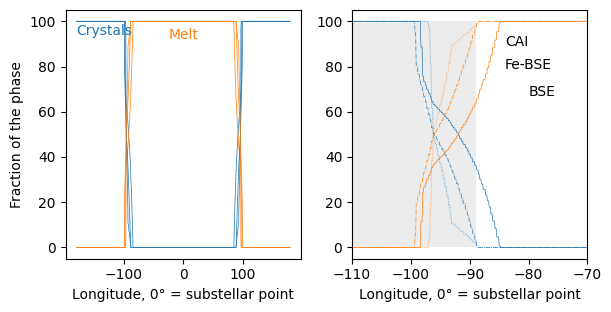

In [38]:
plt.figure(figsize=(6.22,3.22))
ax1 = plt.subplot(1,2,1)
plt.plot(lon, Result_BSE.loc[:,"prct_c"], "-", linewidth=0.5)
plt.plot(lon, Result_BSE.loc[:,"prct_l"], "-", linewidth=0.5)
#plt.plot(Longitude_axis, Result_BSE.loc[:,"prct_g"], "-", linewidth=0.5)

plt.plot(lon, Result_FBSE.loc[:,"prct_c"], "-", linewidth=0.5, color="C0")
plt.plot(lon, Result_FBSE.loc[:,"prct_l"], "-", linewidth=0.5, color="C1")
#plt.plot(lon, Result_FBSE.loc[:,"prct_g"], "-", linewidth=0.5, color="C2")

plt.plot(lon, Result_CAI.loc[:,"prct_c"], "-", linewidth=0.5, color="C0")
plt.plot(lon, Result_CAI.loc[:,"prct_l"], "-", linewidth=0.5, color="C1")
plt.xlabel("Longitude, 0° = substellar point")
plt.ylabel("Fraction of the phase")
plt.annotate("Crystals", xy=(-180, 94), xycoords="data", color="C0", ha="left")
plt.annotate("Melt", xy=(0, 92), xycoords="data", color="C1", ha="center")
#plt.annotate("Gas", xy=(0, 3), xycoords="data", color="C2", ha="center")

ax2 = plt.subplot(1,2,2)
plt.plot(lon, Result_BSE.loc[:,"prct_c"], "-", linewidth=0.5)
plt.plot(lon, Result_BSE.loc[:,"prct_l"], "-", linewidth=0.5)
#plt.plot(Longitude_axis, Result_BSE.loc[:,"prct_g"], "-", linewidth=0.5)

plt.plot(lon, Result_FBSE.loc[:,"prct_c"], "-.", linewidth=0.5, color="C0")
plt.plot(lon, Result_FBSE.loc[:,"prct_l"], "-.", linewidth=0.5, color="C1")
#plt.plot(Longitude_axis, Result_FBSE.loc[:,"prct_g"], "-.", linewidth=0.5, color="C2")

plt.plot(lon, Result_CAI.loc[:,"prct_c"], ":", linewidth=0.5, color="C0")
plt.plot(lon, Result_CAI.loc[:,"prct_l"], ":", linewidth=0.5, color="C1")
plt.xlabel("Longitude, 0° = substellar point")
plt.annotate("BSE", xy=(-80, 67), xycoords="data", color="k", ha="left")
plt.annotate("Fe-BSE", xy=(-80, 79), xycoords="data", color="k", ha="center")
plt.annotate("CAI", xy=(-82, 89), xycoords="data", color="k", ha="center")

# shaded areas for night, pen, day
fill_un_pen_full_regions(0,100)

# limits
plt.xlim(-110, -70)

plt.tight_layout()
plt.savefig("./figures/Phases_profile_presentation.pdf")

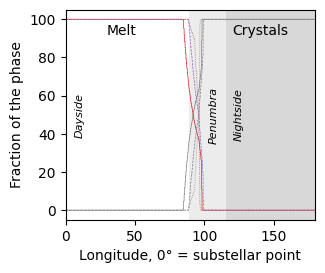

In [39]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(3.22,6))
ax1 = plt.subplot(2,1,1)
plt.plot(lon, Result_BSE.loc[:,"prct_c"], "-", linewidth=0.5, color="grey")
plt.plot(lon, Result_BSE.loc[:,"prct_l"], "-", linewidth=0.5, color="C3")
#plt.plot(lon, Result_BSE.loc[:,"prct_g"], "-", linewidth=0.5)

plt.plot(lon, Result_FBSE.loc[:,"prct_c"], "--", linewidth=0.5, color="grey")
plt.plot(lon, Result_FBSE.loc[:,"prct_l"], "--", linewidth=0.5, color="C4")
#plt.plot(lon, Result_FBSE.loc[:,"prct_g"], "-", linewidth=0.5, color="C2")

plt.plot(lon, Result_CAI.loc[:,"prct_c"], ":", linewidth=0.5, color="grey")
plt.plot(lon, Result_CAI.loc[:,"prct_l"], ":", linewidth=0.5, color="C5")

plt.annotate("Crystals", xy=(120, 92), xycoords="data", color="k", ha="left")
plt.annotate("Melt", xy=(40, 92), xycoords="data", color="k", ha="center")
#plt.annotate("Gas", xy=(0, 3), xycoords="data", color="C2", ha="center")

# shaded areas for night, pen, day
fill_un_pen_full_regions(-5,105)
ax1.annotate("Nightside", (125,50), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")
ax1.annotate("Dayside", (10,50), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")
ax1.annotate("Penumbra", (107,50), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")

# axes stuffs
plt.xlabel("Longitude, 0° = substellar point")
ax1.set_ylabel("Fraction of the phase")

# set limits
ax1.set_xlim(0, 180)
ax1.set_ylim(-5,105)

# annotations
plt.annotate("BSE", xy=(-80, 67), xycoords="data", color="k", ha="left")
plt.annotate("Fe-BSE", xy=(-80, 79), xycoords="data", color="k", ha="center")
plt.annotate("CAI", xy=(-82, 89), xycoords="data", color="k", ha="center")

#plt.tight_layout()
plt.savefig("./figures/Phases_profile_papier.pdf", bbox_inches='tight')

## Viscosity as a function of longitude

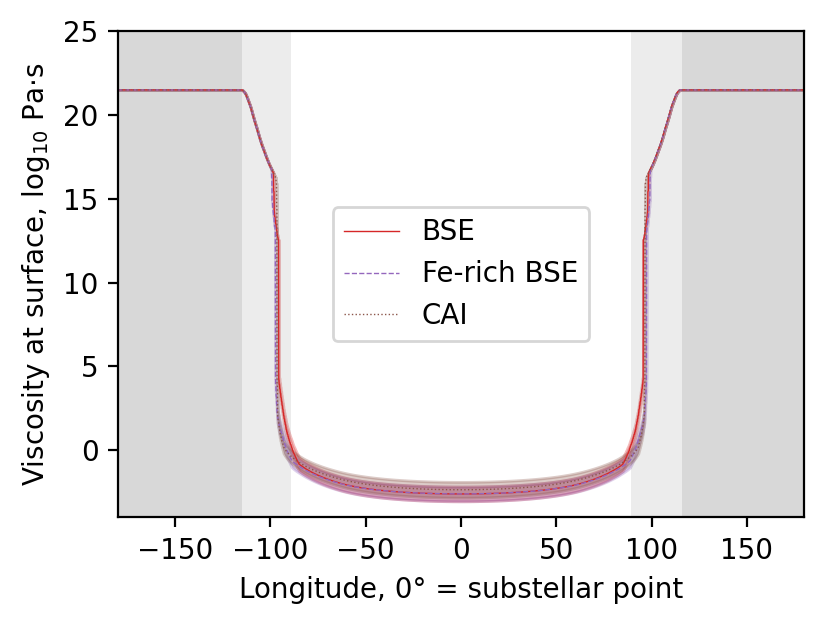

In [40]:
plt.figure(figsize=(4.22,3.22), dpi=200)

# BSE composition
plt.plot(lon, Result_BSE.visco, "-", linewidth=0.5, color="C3", label="BSE")
plt.fill_between(lon, 
                 Result_BSE.visco-Result_BSE.visco_std,
                 Result_BSE.visco+Result_BSE.visco_std,
                 alpha=0.3, color="C3")

# Fe-rich BSE
plt.plot(lon, Result_FBSE.visco, "--", linewidth=0.5, color="C4", label="Fe-rich BSE")
plt.fill_between(lon, 
                 Result_FBSE.visco-Result_FBSE.visco_std,
                 Result_FBSE.visco+Result_FBSE.visco_std,
                 alpha=0.3, color="C4")

# CAI compo
plt.plot(lon, Result_CAI.visco, ":", linewidth=0.5, color="C5", label="CAI")
plt.fill_between(lon, 
                 Result_CAI.visco-Result_CAI.visco_std,
                 Result_CAI.visco+Result_CAI.visco_std,
                 alpha=0.3, color="C5")

# shaded areas and limits
fill_un_pen_full_regions(-4, 25)
plt.ylim(-4, 25)
plt.xlim(-180, 180)

# axes labels
plt.xlabel("Longitude, 0° = substellar point")
plt.ylabel("Viscosity at surface, log$_{10}$ Pa$\cdot$s")

# add legend
plt.legend(loc="center")
plt.tight_layout()

plt.savefig("./figures/Viscosity_profile_full.pdf")

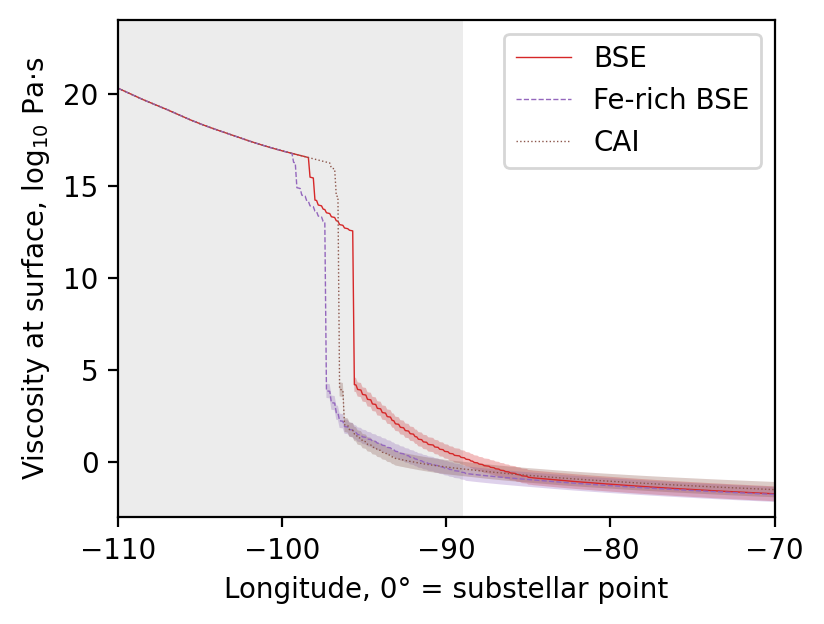

In [41]:
plt.figure(figsize=(4.22,3.22), dpi=200)

# BSE composition
plt.plot(lon, Result_BSE.visco, "-", linewidth=0.5, color="C3", label="BSE")
plt.fill_between(lon, 
                 Result_BSE.visco-Result_BSE.visco_std,
                 Result_BSE.visco+Result_BSE.visco_std,
                 alpha=0.3, color="C3", edgecolor="none")

# Fe-rich BSE
plt.plot(lon, Result_FBSE.visco, "--", linewidth=0.5, color="C4", label="Fe-rich BSE")
plt.fill_between(lon, 
                 Result_FBSE.visco-Result_FBSE.visco_std,
                 Result_FBSE.visco+Result_FBSE.visco_std,
                 alpha=0.3, color="C4", edgecolor="none")

# CAI compo
plt.plot(lon, Result_CAI.visco, ":", linewidth=0.5, color="C5", label="CAI")
plt.fill_between(lon, 
                 Result_CAI.visco-Result_CAI.visco_std,
                 Result_CAI.visco+Result_CAI.visco_std,
                 alpha=0.3, color="C5", edgecolor="none")

# shaded areas and limits
fill_un_pen_full_regions(-4, 25)
plt.xlim(-110,-70)
plt.ylim(-3,24)

# axes labels
plt.xlabel("Longitude, 0° = substellar point")
plt.ylabel("Viscosity at surface, log$_{10}$ Pa$\cdot$s")

# set legend
plt.legend(loc="upper right")

plt.tight_layout()

plt.savefig("./figures/Viscosity_profile_shore.pdf")

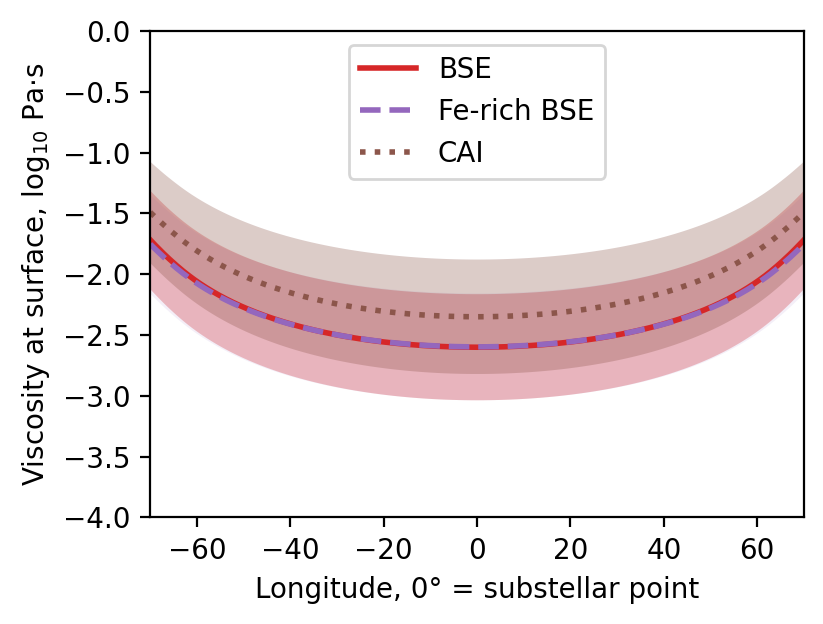

In [42]:
plt.figure(figsize=(4.22,3.22), dpi=200)
plt.plot(lon, Result_BSE.visco, "-", linewidth=2.0, color="C3", label="BSE")
plt.fill_between(lon, 
                 Result_BSE.visco-Result_BSE.visco_std,
                 Result_BSE.visco+Result_BSE.visco_std,
                 alpha=0.3, color="C3", edgecolor="none")

plt.fill_betweenx([-2,23],-180,-90, color="grey", alpha=0.2)
plt.fill_betweenx([-2,23],90,180, color="grey", alpha=0.2)
plt.legend(loc=9)
plt.xlabel("Longitude, 0° = substellar point")
plt.ylabel("Viscosity at surface, log$_{10}$ Pa$\cdot$s")
plt.xlim(-70,70)
plt.ylim(-4,0)
plt.tight_layout()

plt.savefig("./figures/Viscosity_profile_center_1.pdf")

plt.plot(lon, Result_FBSE.visco, "--", linewidth=2.0, color="C4", label="Fe-rich BSE")
plt.fill_between(lon, 
                 Result_FBSE.visco-Result_FBSE.visco_std,
                 Result_FBSE.visco+Result_FBSE.visco_std,
                 alpha=0.1, facecolor="C4", edgecolor="none")
plt.legend(loc=9)

plt.savefig("./figures/Viscosity_profile_center_2.pdf")


plt.plot(lon, Result_CAI.visco, ":", linewidth=2.0, color="C5", label="CAI")
plt.fill_between(lon, 
                 Result_CAI.visco-Result_CAI.visco_std,
                 Result_CAI.visco+Result_CAI.visco_std,
                 alpha=0.3, color="C5", edgecolor="none")
plt.legend(loc=9)

plt.savefig("./figures/Viscosity_profile_center_3.pdf")

### Figure for paper

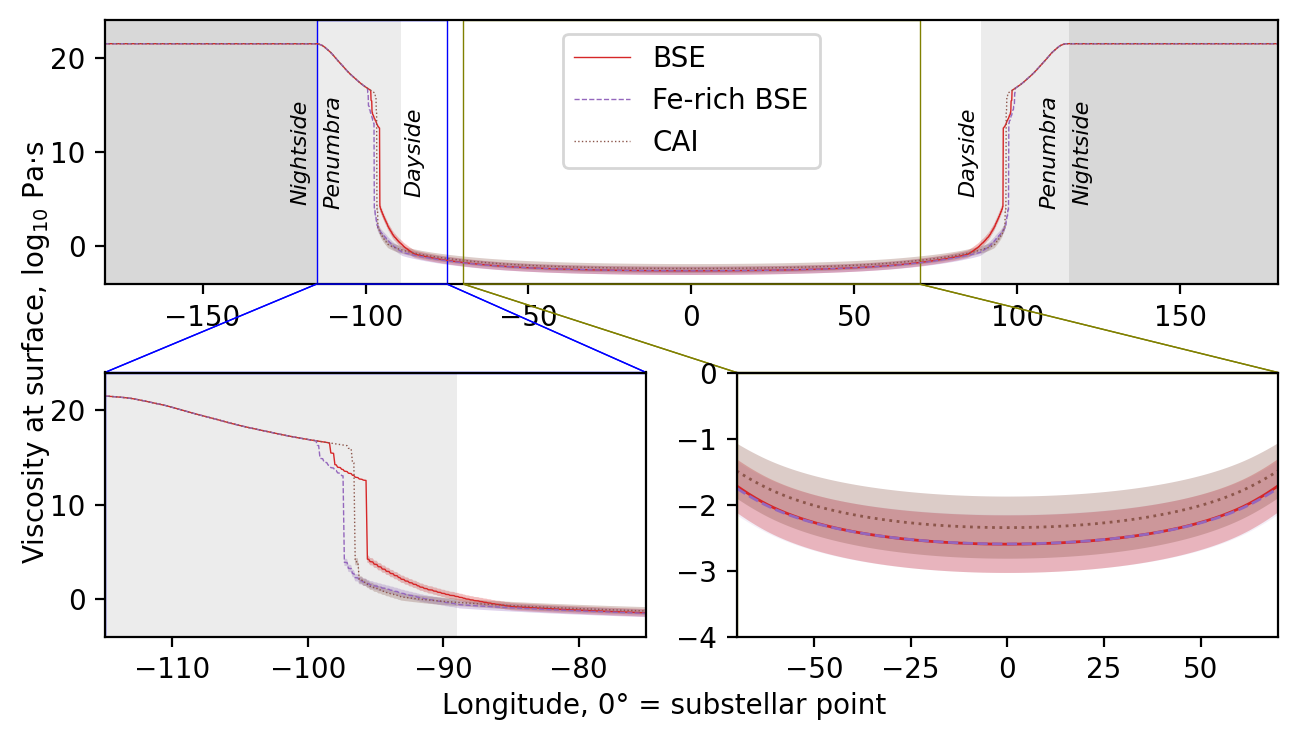

In [43]:
fig = plt.figure(figsize=(6.44,3.62), dpi=200)

###
# FIGURE TOP
###
ax3a = plt.subplot(2,2,(1,2))

# BSE composition
plt.plot(lon, Result_BSE.visco, "-", linewidth=0.5, color="C3", label="BSE")
plt.fill_between(lon, 
                 Result_BSE.visco-Result_BSE.visco_std,
                 Result_BSE.visco+Result_BSE.visco_std,
                 alpha=0.3, color="C3", edgecolor="none")

# Fe-rich BSE
plt.plot(lon, Result_FBSE.visco, "--", linewidth=0.5, color="C4", label="Fe-rich BSE")
plt.fill_between(lon, 
                 Result_FBSE.visco-Result_FBSE.visco_std,
                 Result_FBSE.visco+Result_FBSE.visco_std,
                 alpha=0.3, color="C4", edgecolor="none")

# CAI compo
plt.plot(lon, Result_CAI.visco, ":", linewidth=0.5, color="C5", label="CAI")
plt.fill_between(lon, 
                 Result_CAI.visco-Result_CAI.visco_std,
                 Result_CAI.visco+Result_CAI.visco_std,
                 alpha=0.3, color="C5", edgecolor="none")

# shaded areas
fill_un_pen_full_regions(-4, 25)

# set legend
plt.legend(loc=9, fontsize=10)

# set axes 
plt.xlim(-180,180)
plt.ylim(-4,24)

##
# FIGURE BOTTOM LEFT
##

ax3b = plt.subplot(2,2,3)
# BSE composition
plt.plot(lon, Result_BSE.visco, "-", linewidth=0.5, color="C3", label="BSE")
plt.fill_between(lon, 
                 Result_BSE.visco-Result_BSE.visco_std,
                 Result_BSE.visco+Result_BSE.visco_std,
                 alpha=0.3, color="C3", edgecolor="none")

# Fe-rich BSE
plt.plot(lon, Result_FBSE.visco, "--", linewidth=0.5, color="C4", label="Fe-rich BSE")
plt.fill_between(lon, 
                 Result_FBSE.visco-Result_FBSE.visco_std,
                 Result_FBSE.visco+Result_FBSE.visco_std,
                 alpha=0.3, color="C4", edgecolor="none")

# CAI compo
plt.plot(lon, Result_CAI.visco, ":", linewidth=0.5, color="C5", label="CAI")
plt.fill_between(lon, 
                 Result_CAI.visco-Result_CAI.visco_std,
                 Result_CAI.visco+Result_CAI.visco_std,
                 alpha=0.3, color="C5", edgecolor="none")

# shaded areas for night, pen, day
fill_un_pen_full_regions(-4, 25)

# set axes 
plt.xlim(-115,-75)
plt.ylim(-4,24)

##
# FIGURE BOTTOM RIGHT
##
ax3c = plt.subplot(2,2,4)
plt.plot(lon, Result_BSE.visco, "-", linewidth=1.0, color="C3", label="BSE")
plt.fill_between(lon, 
                 Result_BSE.visco-Result_BSE.visco_std,
                 Result_BSE.visco+Result_BSE.visco_std,
                 alpha=0.3, color="C3", edgecolor="none")

# shaded areas for night, pen, day
fill_un_pen_full_regions(-4, 25)

plt.xlim(-70,70)
plt.ylim(-4,0)

plt.plot(lon, Result_FBSE.visco, "--", linewidth=1.0, color="C4", label="Fe-rich BSE")
plt.fill_between(lon, 
                 Result_FBSE.visco-Result_FBSE.visco_std,
                 Result_FBSE.visco+Result_FBSE.visco_std,
                 alpha=0.1, facecolor="C4", edgecolor="none")

plt.plot(lon, Result_CAI.visco, ":", linewidth=1.0, color="C5", label="CAI")
plt.fill_between(lon, 
                 Result_CAI.visco-Result_CAI.visco_std,
                 Result_CAI.visco+Result_CAI.visco_std,
                 alpha=0.3, color="C5", edgecolor="none")

plt.tight_layout()

fig.text(0.5, 0.0, 'Longitude, 0° = substellar point', ha='center')
fig.text(0.0, 0.5, 'Viscosity at surface, log$_{10}$ Pa$\cdot$s', va='center', rotation='vertical')

zoom_effect01(ax3a, ax3b, -115, -75, linewidth=0.5, fc="none", ec="blue")

zoom_effect01(ax3a, ax3c, -70, 70, linewidth=0.5, fc="none", ec="olive")

ax3a.annotate("Nightside", (-120,10), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")
ax3a.annotate("Dayside", (-85,10), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")
ax3a.annotate("Penumbra", (-110,10), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")

ax3a.annotate("Nightside", (120,10), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")
ax3a.annotate("Dayside", (85,10), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")
ax3a.annotate("Penumbra", (110,10), ha="center", va="center", rotation=90, fontsize=8, fontstyle="italic")

plt.savefig("./figures/viscosity_profile_all.pdf",bbox_inches='tight')